# Test advanced masking for fdETCCDI
- author: Johannes L. Fjeldså
- email: johannes.larsen.fjeldså@nmbu.no
## Import libraries

https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from xclim import ensembles as ens

from src.preproces import *
from src.plotting import *
from src.create_masked_climatology import *
from pathlib import Path


file_handler = Handle_Files()
var = 'fdETCCDI'
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/' + var
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

## Create climatologies

First investigation of raw file we see that it condains the timedelta64[ns] format so we must include: *dataset[var] = (dataset[var].astype(np.float64) / (24\*3600\*10\*\*9)).astype(np.int64)* in '02 - Create temporal climatology.py'. After running that we can investigate the mapplots in order to detect interesting regions. 

[2024-02-27 10:45:01.612] [Process: 1804021] [error] [1709027101612296037-Global] TileDB internal: Error initializing thread pool of concurrency level 0; Resource temporarily unavailable
[2024-02-27 10:45:01.626] [Process: 1804021] [error] [1709027101612296037-Global] TileDB internal: Error initializing thread pool of concurrency level 0; Resource temporarily unavailable


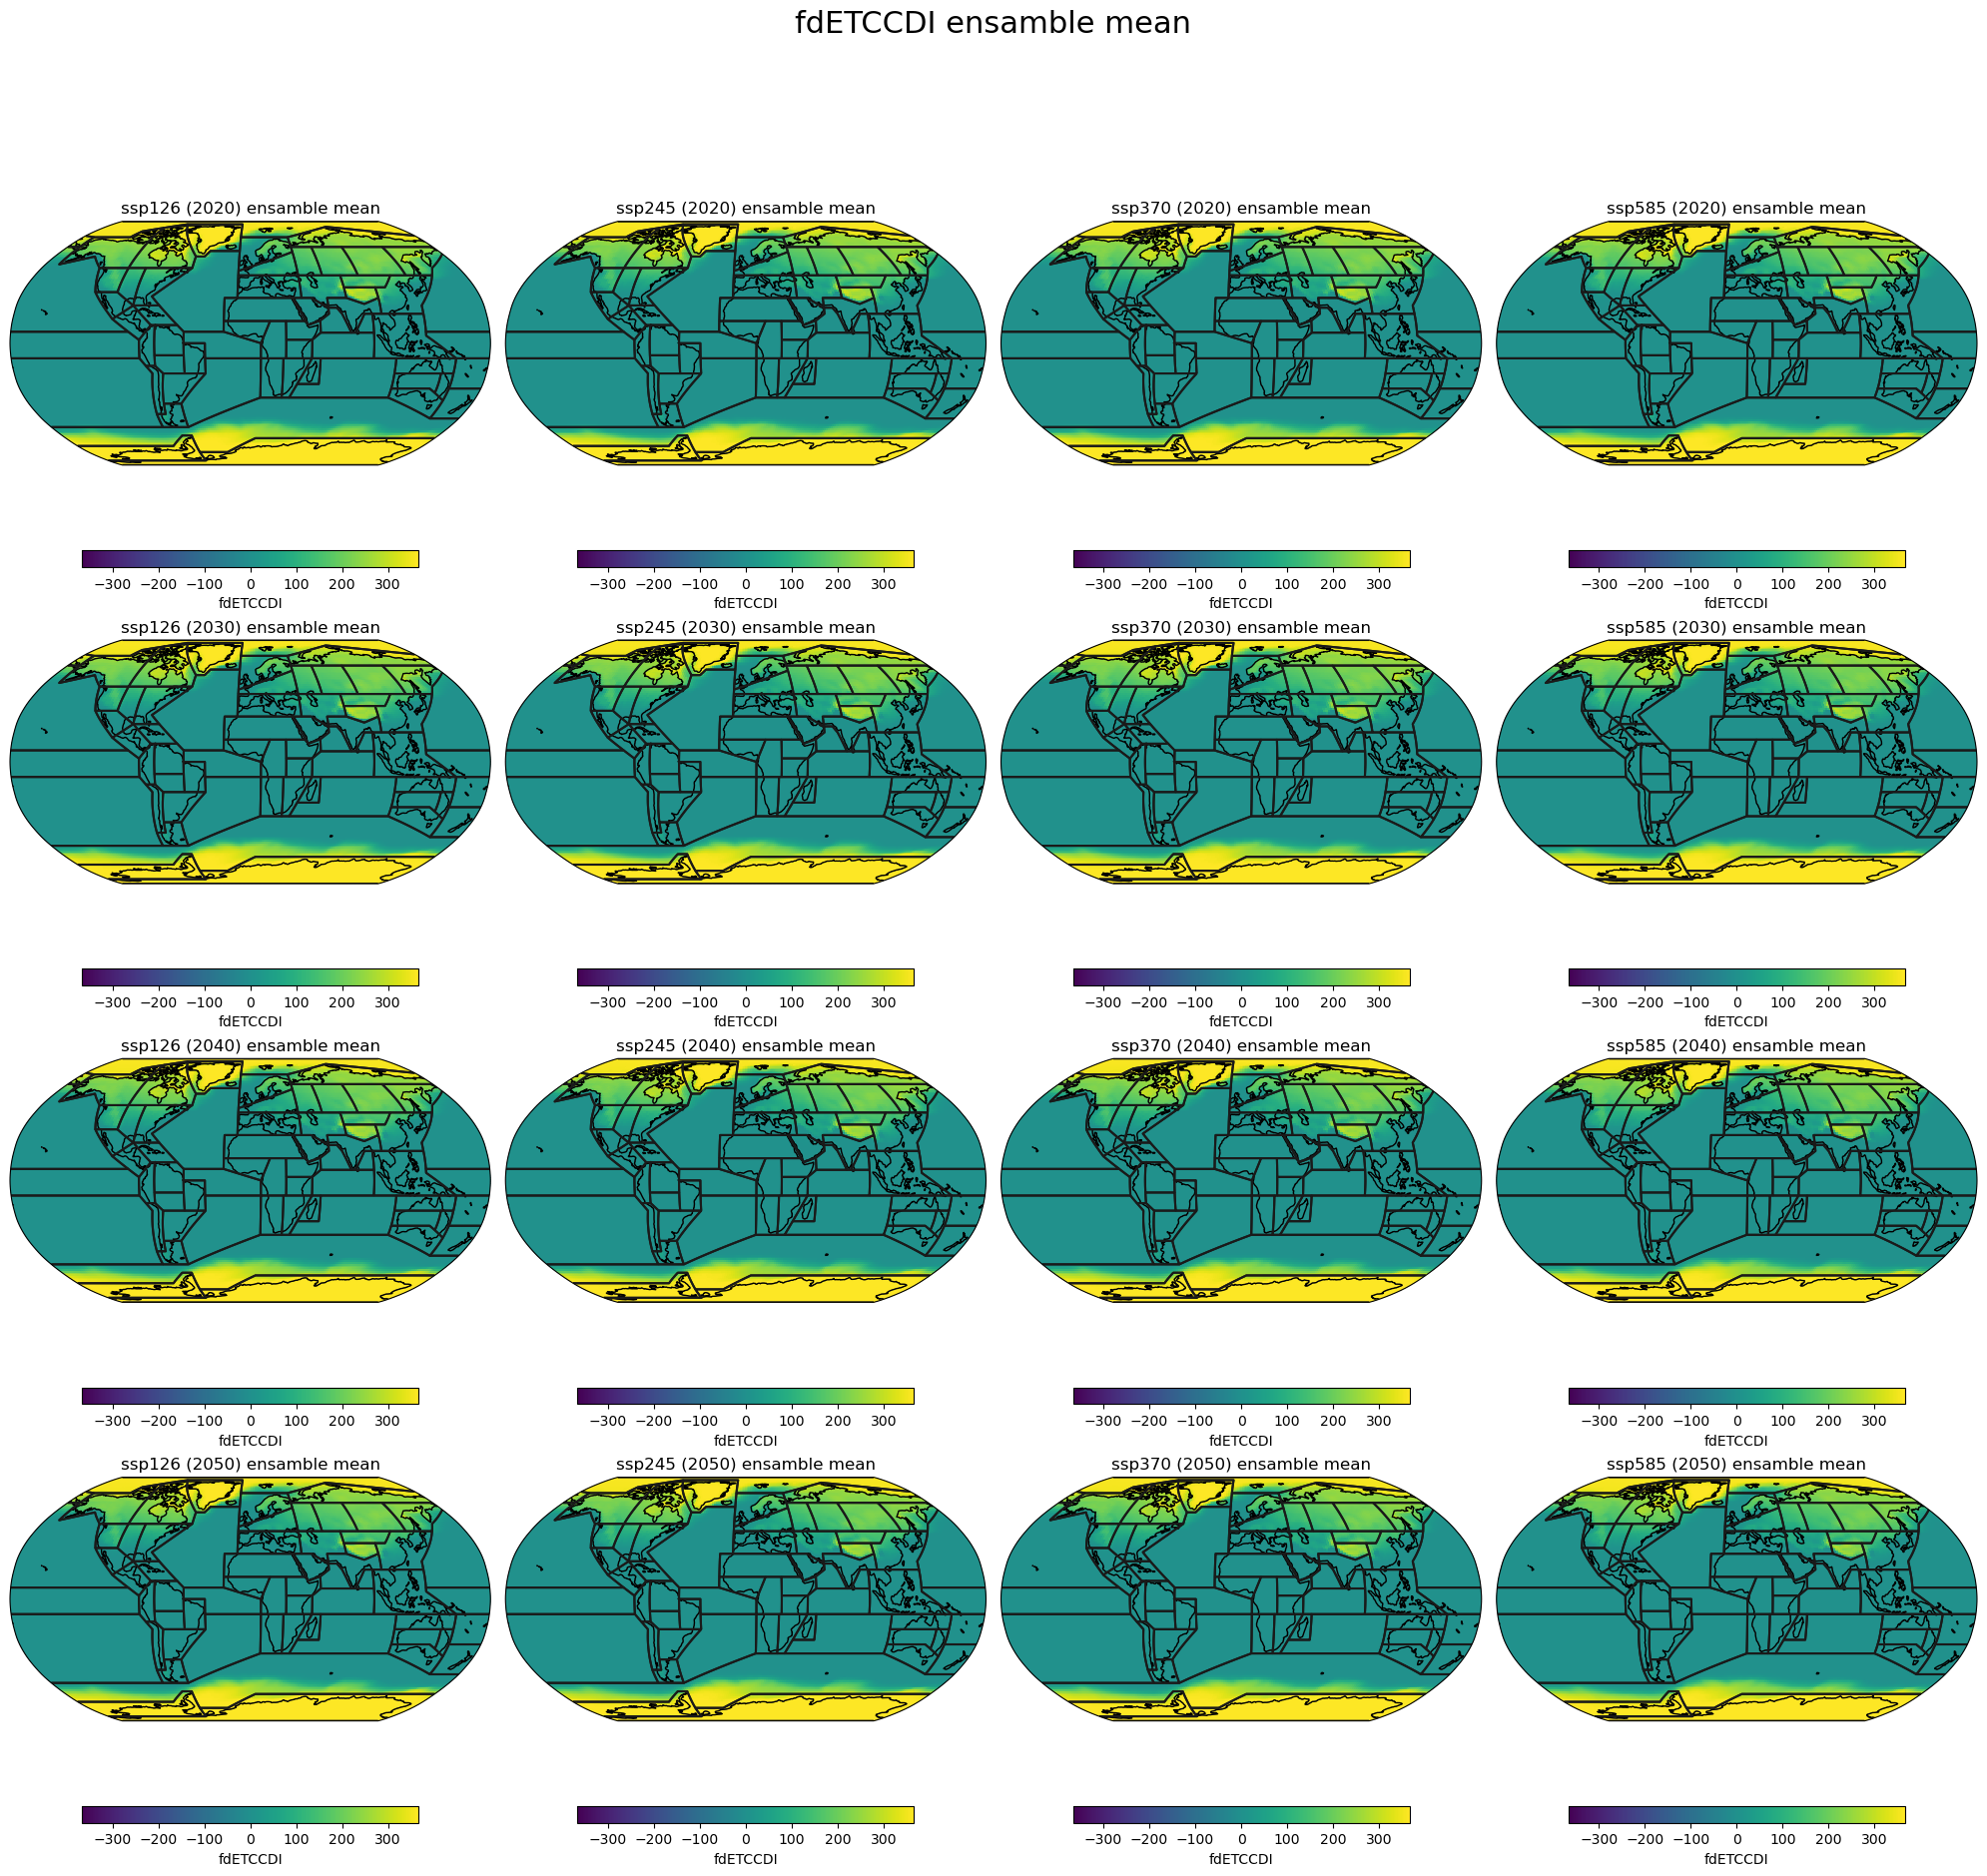

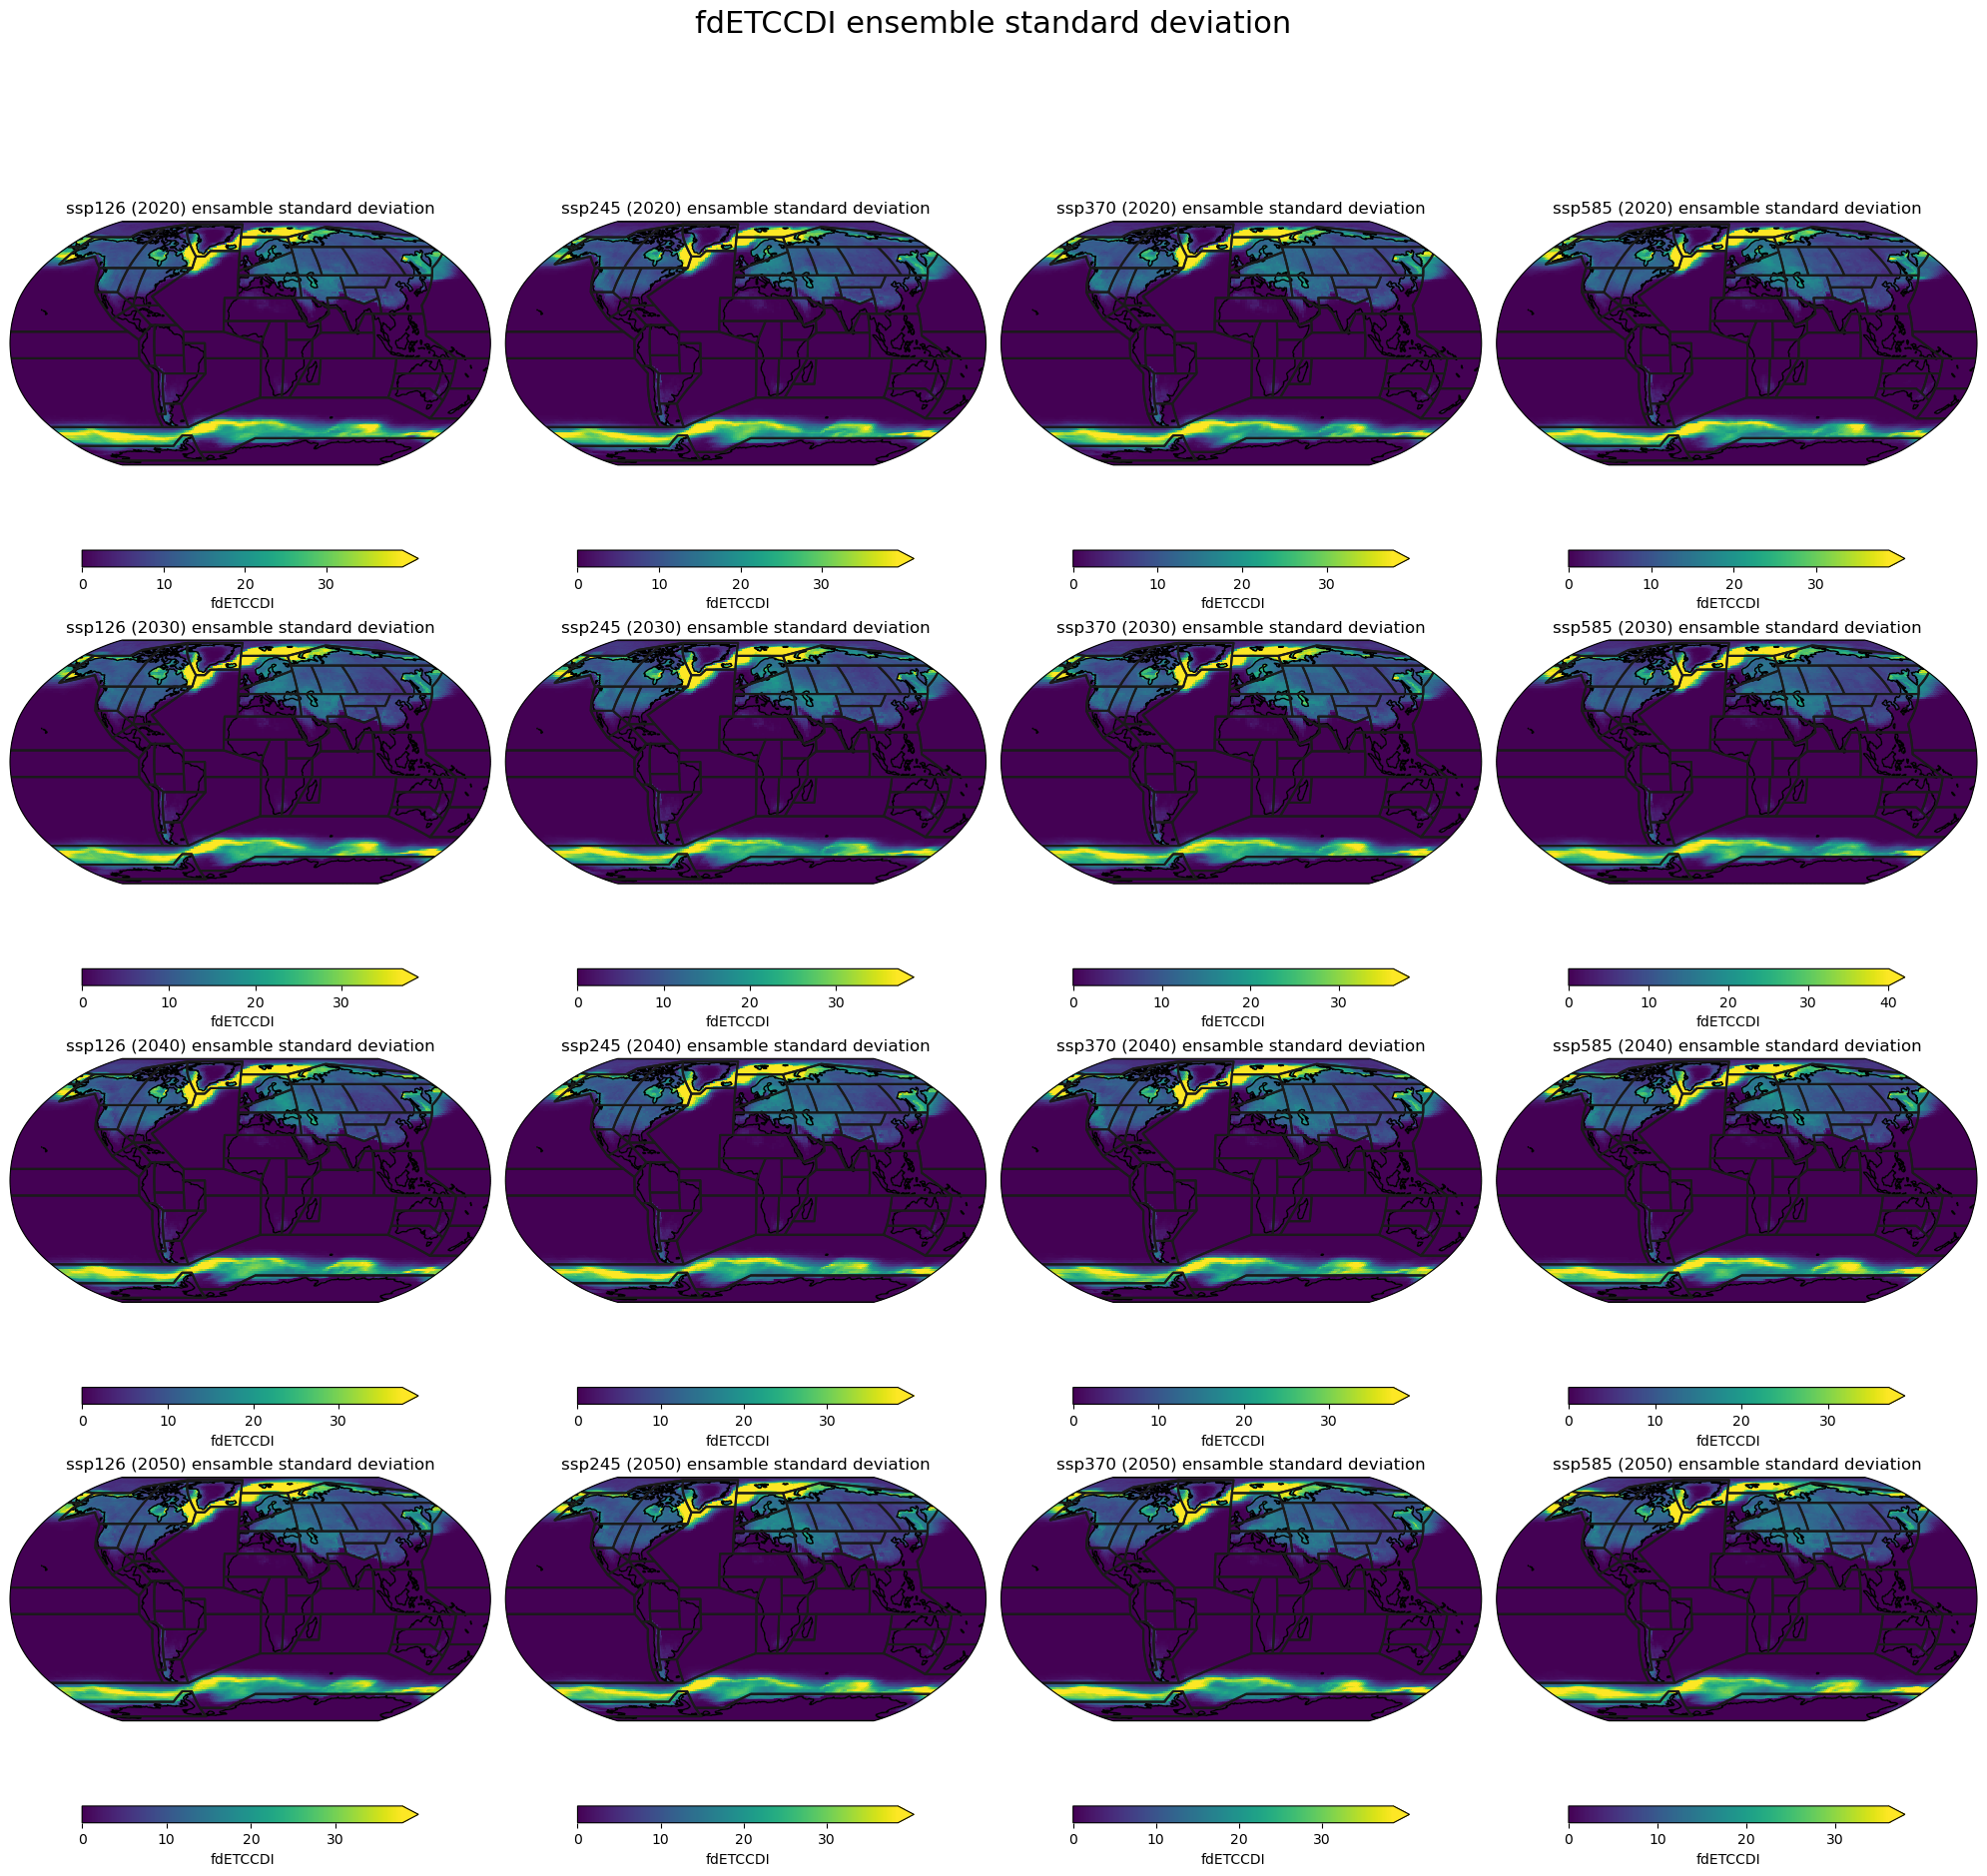

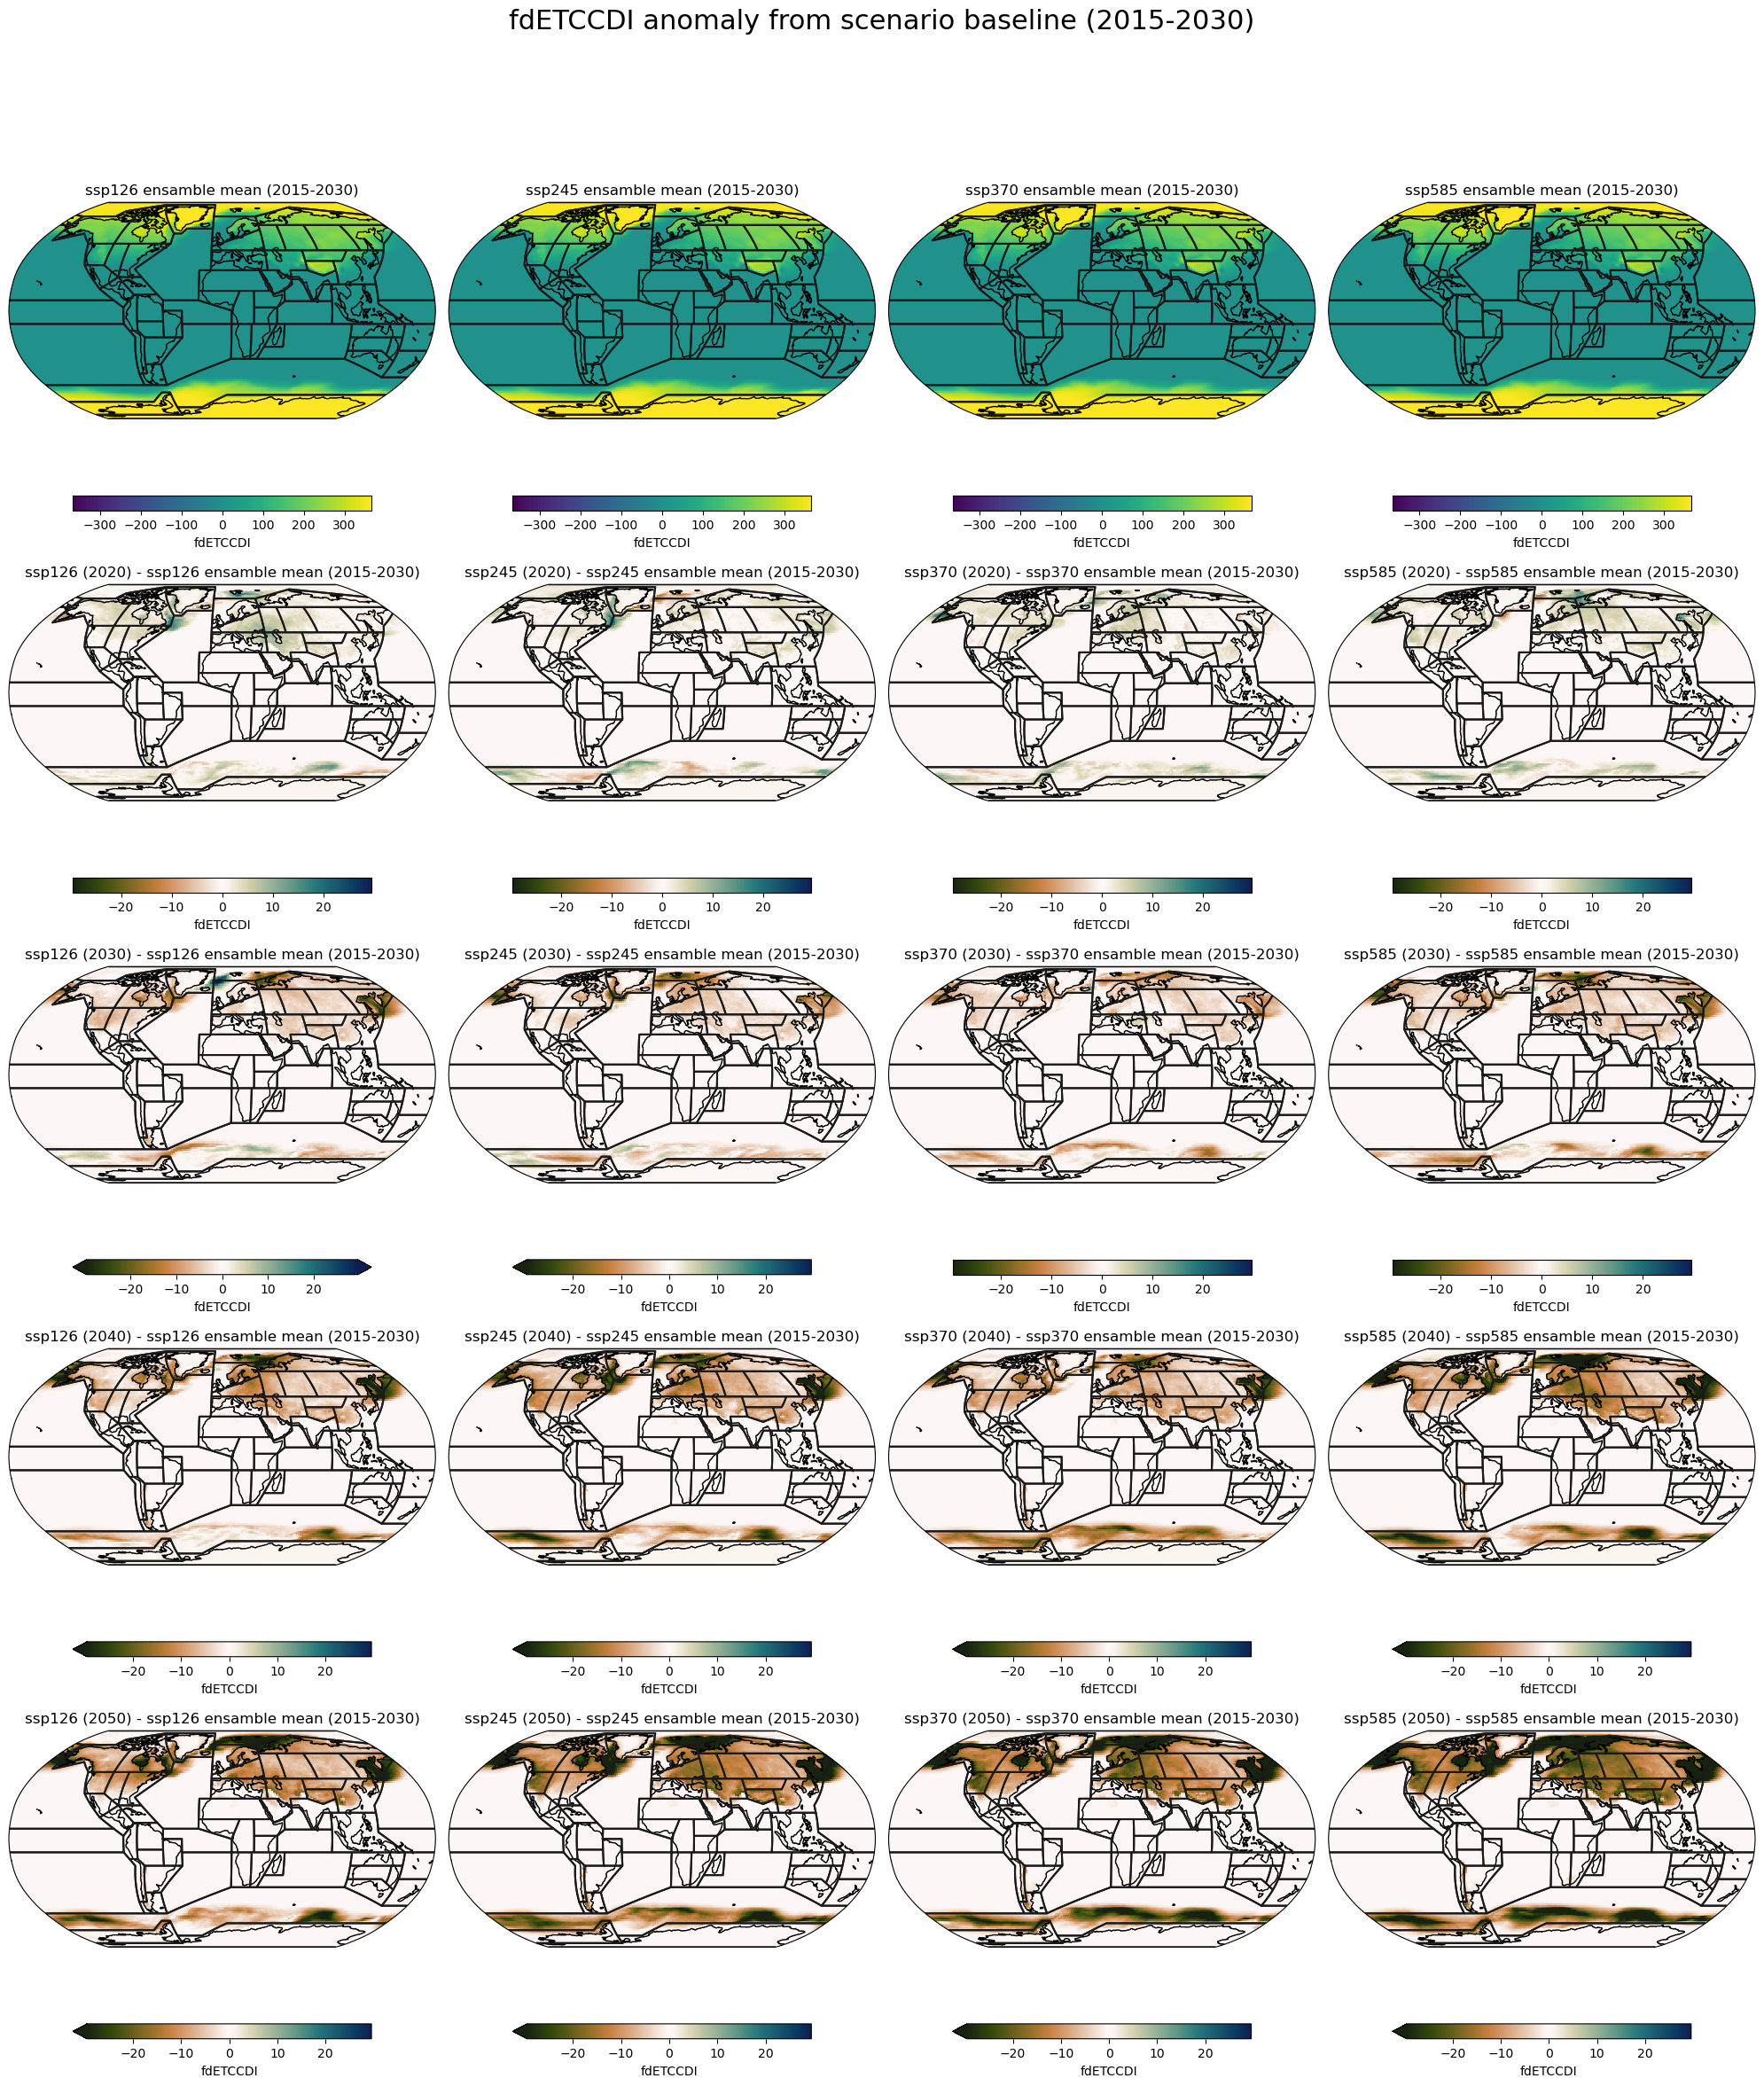

In [2]:
ensambles = {scenario: ens.create_ensemble(Path(main_data_folder + '/' + scenario).glob("*.nc")) for scenario in SSPs}
plot_mapplots_for_investigation(ensambles, var, [2020, 2030, 2040, 2050], SSPs)

## Create unmasked spatial climatologies

In [4]:
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/' + var
main_save_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies/nomask/' + var

for scenario in SSPs:
    data_folder = '/'.join([main_data_folder, scenario])
    save_folder = '/'.join([main_save_folder, scenario])
    for file_name in file_handler.get_all_netcdf_files_in_dir(data_folder):
        ds = file_handler.read_netcdf_to_xr(directory=data_folder, file_name=file_name)
        weights = np.cos(np.deg2rad(ds['lat']))
        weights.name = "weights"        
        preprocesser.create_spatial_climatology(ds, var, 
                                                weights, 
                                                climatology_type='global', 
                                                save_to_dataset=True, 
                                                file_name=file_name.replace('.nc', f'_glob.nc'), 
                                                directory=save_folder, 
                                                is_original_name=False, 
                                                re_open=False)

## Create masked climatologies
frost days at large follows the same pattern as the growing season length and so we apply the same masks. 

In [3]:
test_file = file_handler.read_netcdf_to_xr('/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/fdETCCDI/ssp245/fdETCCDI_yr_ACCESS-ESM1-5_ssp245_r3i1p1f1_2015-2100.nc')
lat_mask_30N_70N = create_latitude_mask(min_lat=30, max_lat=70, 
                                        var='fdETCCDI',
                                        new_mask_name='lat_mask_30N_70N',
                                        test_file=test_file)
land_mask_30N_70N = create_land_sea_latitude_mask(min_lat=30, max_lat=70, 
                                                  new_mask_name='land_mask_30N_70N', 
                                                  land=True)

for mask, file_name in zip([lat_mask_30N_70N, land_mask_30N_70N], 
                           ['lat_mask_30N_70N_ACCESS-ESM1-5.nc', 'land_mask_30N_70N_ACCESS-ESM1-5.nc']):
    file_handler.save_dataset_to_netcdf(mask, 
                                        file_name=file_name,
                                        directory='/nird/home/johannef/Masterthesis_S23 DataFiles/masks')

In [ ]:
for mask_name in ['lat_mask_30N_70N', 
                  'land_mask', 'land_mask_30N_70N']:
    create_masked_climatologies(mask_name, var,
                                excisting_mask=True, 
                                test_file=test_file)

The newer masking yields:

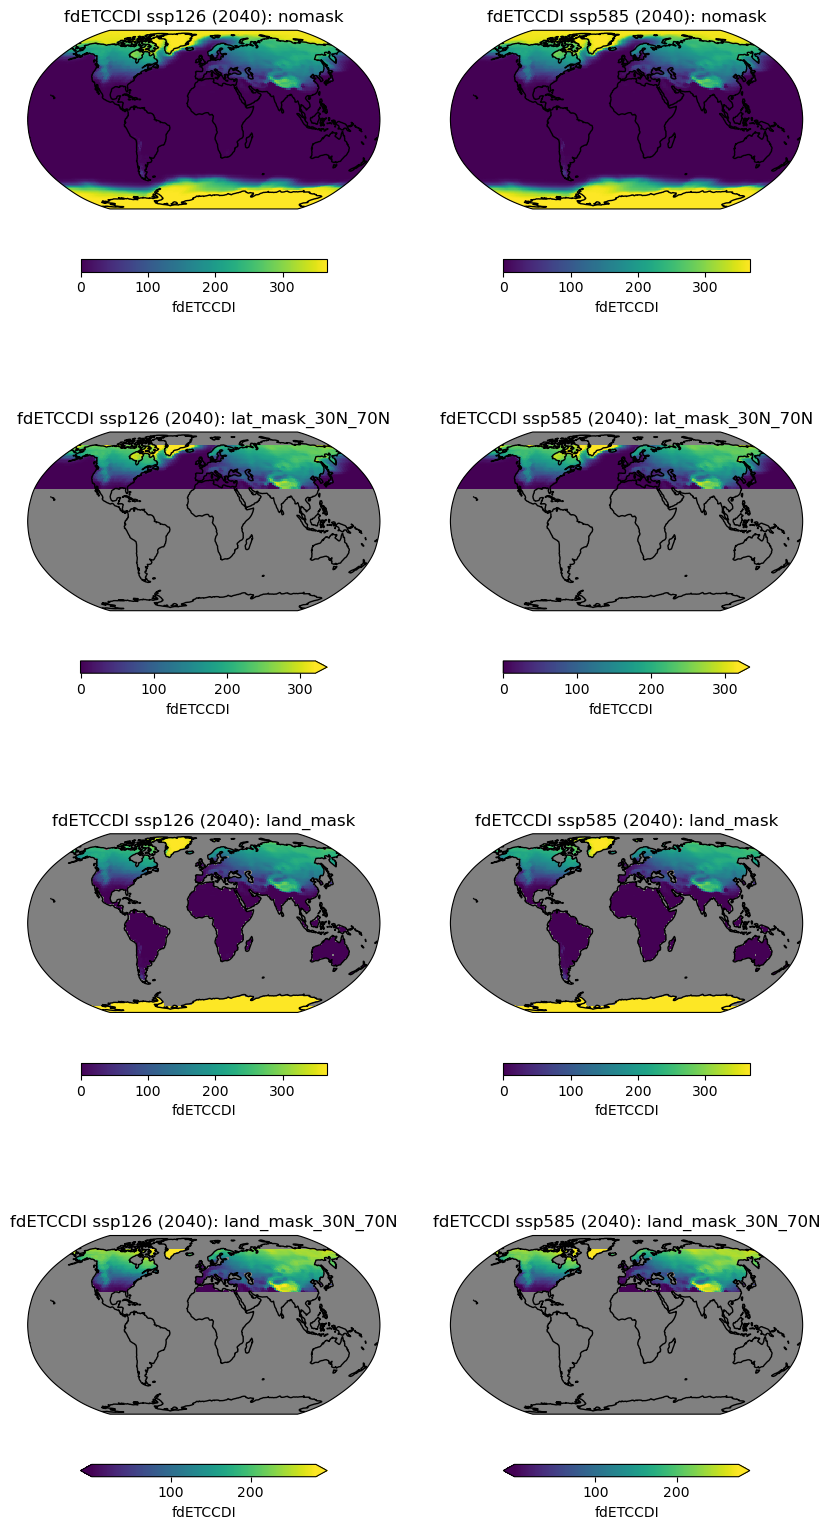

In [5]:
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies'
SSPs = ['ssp126', 'ssp585']
var = 'fdETCCDI'
mask_names = ['nomask', 'lat_mask_30N_70N', 
              'land_mask', 'land_mask_30N_70N']
fig, axs = plt.subplots(ncols=len(SSPs), nrows=len(mask_names), 
                        figsize=(5*len(SSPs), 5*len(mask_names)),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="gray"))
axs = axs.flatten()

i = 0
for mask_name in mask_names:
    mask_data_dir = '/'.join([main_data_dir, mask_name, var])
    for scenario in SSPs:
        data_dir = '/'.join([mask_data_dir, scenario])
        ensamble = ens.create_ensemble(Path(data_dir).glob("*.nc")) 
        ensamble_mean = ensamble.mean(dim='realization') 

        plot_on_map(ensamble_mean.sel(year=2040)[var], ax=axs[i], title=f'{var} {scenario} ({2040}): {mask_name}')

        i += 1

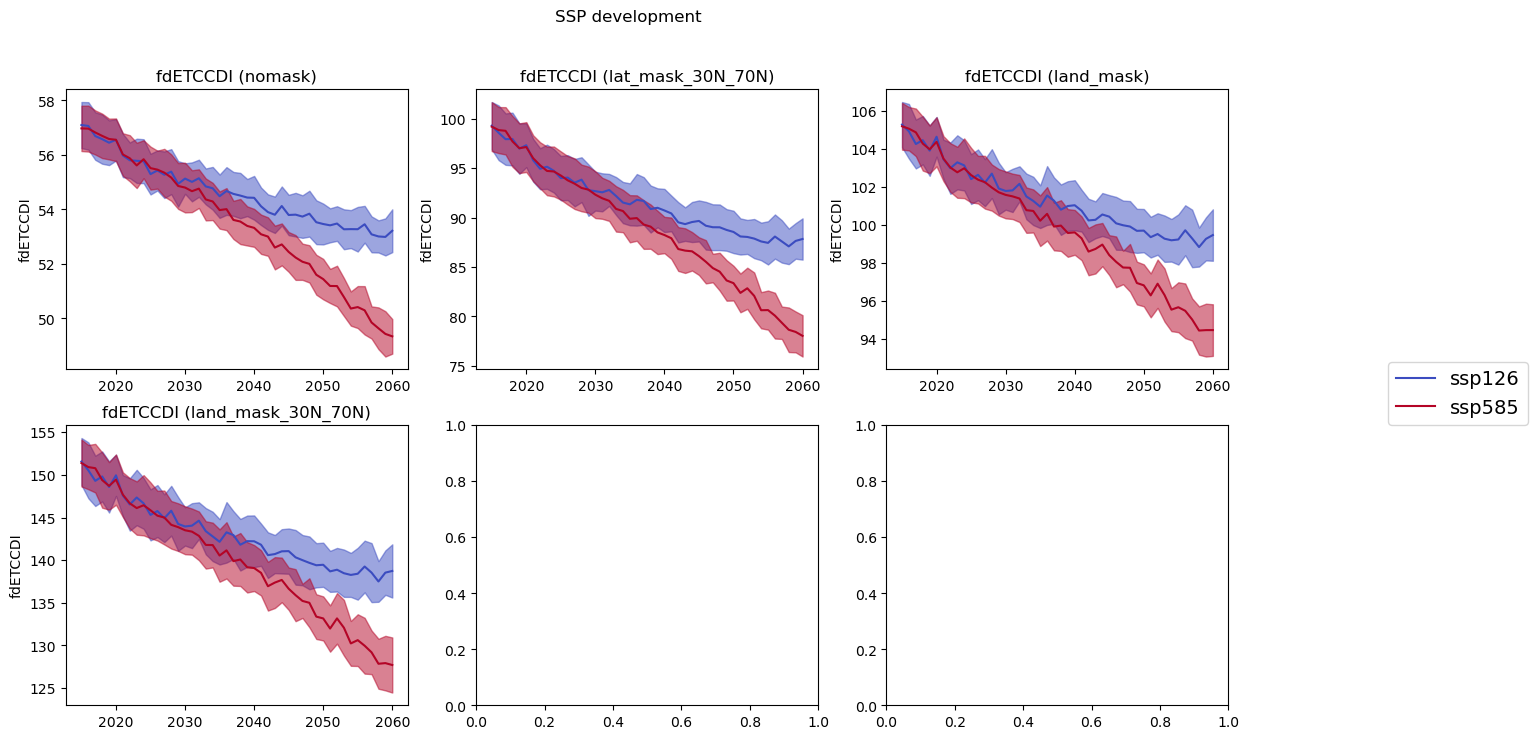

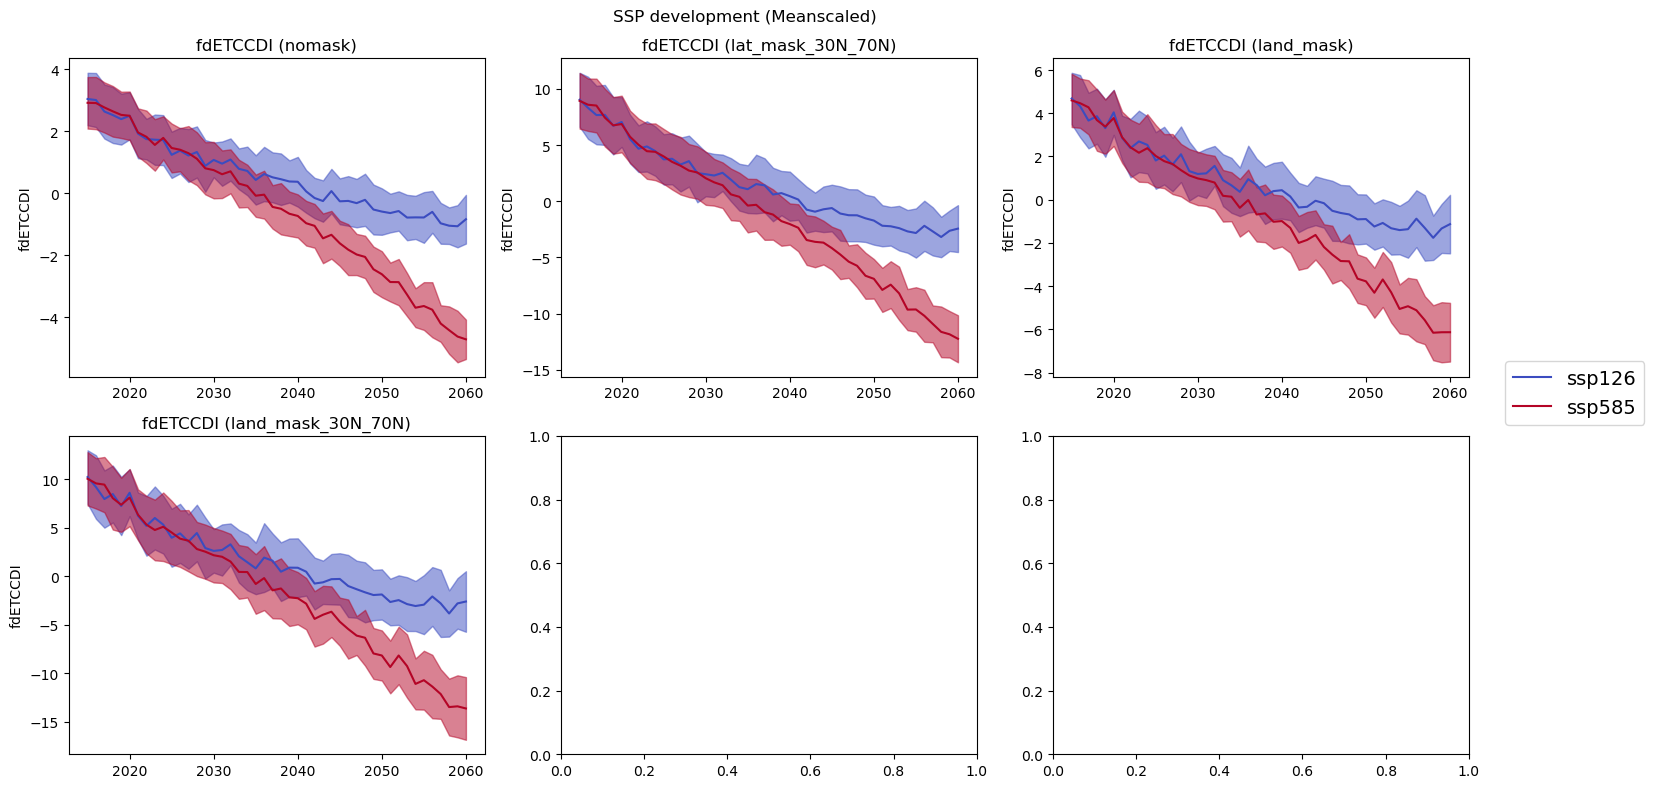

In [6]:
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies'
plot_annual_global_ensambles(main_data_dir, SSPs, var,
                             mask_names, temporal_range=(2015, 2060))

keeping:
- nomask
- land and lat 30-70N